In [ ]:
# default_exp landcover

# Conserved proportions of land cover classes 


One indicator is the conserved area for some land cover class, such as swamps or forests. 

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

import geopandas as gpd
import rasterio as rio
import rasterio.mask as rio_mask
import os
import pandas as pd
from pathlib import Path
from shapely.geometry import box, Polygon
import numpy as np
import matplotlib.pyplot as plt

# Data sources used

* Corine land cover mosaics by SYKE
  * [CLC2000](https://ckan.ymparisto.fi/dataset/corine-maanpeite-2000)
  * [CLC2006](https://ckan.ymparisto.fi/dataset/corine-maanpeite-2006)
  * [CLC2012](https://ckan.ymparisto.fi/dataset/corine-maanpeite-2012)
  * [CLC2018](https://ckan.ymparisto.fi/dataset/corine-maanpeite-2018)
* [NATURA2000 conservation areas](https://ckan.ymparisto.fi/dataset/natura2000-alueet)
* [CDDA 16](https://www.eea.europa.eu/data-and-maps/data/nationally-designated-areas-national-cdda-16)

## Natura2000

Natura has 3 levels:
* SPA: Special Protection Areas
* SAC: Special Areas of Conservation
* SCI: Sites of Community Importance

In [ ]:
natura_path = Path('../data/natura')
natura_spa = gpd.read_file(natura_path/'NaturaSPA_alueet.shp')
natura_sac = gpd.read_file(natura_path/'NaturaSAC_alueet.shp')
natura_sci = gpd.read_file(natura_path/'NaturaSCI_alueet.shp')

Merge them to a single dataframe

In [ ]:
natura_spa['level'] = 'SPA'
natura_sac['level'] = 'SAC'
natura_sci['level'] = 'SCI'
natura = pd.concat((natura_spa, natura_sac, natura_sci))

In [ ]:
natura.to_file('../data/natura/Natura_alueet_merged.shp')

/home/jannem/miniconda3/envs/dronedetector-cpu/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## CDDA16

CDDA contains [IUCN category](http://dd.eionet.europa.eu/vocabulary/cdda/IucnCategoryValue) as one of its attributes, which can be one of the following:

|Id|Label|
|--|-----|
|II|National Park|
|III|Natural monument or feature|
|IV|Habitat/species management area|
|Ia|Strict nature reserve|
|Ib|Wilderness area|
|V|Protected landscape/seascape|
|VI|Protected area with sustainable ose of natural resources|
|notApplicable|Not applicable|
|notAssigned|Not assigned|
|notReported|Not reported|


In [ ]:
cdda_path = Path('../data/cdda')
cdda_geoms = gpd.read_file(cdda_path/'CDDA_2021_v01_public.gpkg', layer='ProtectedSite')
cdda_areas = gpd.read_file(cdda_path/'CDDA_2021_v01_public.gpkg', layer='DesignatedArea')

In [ ]:
cdda = cdda_geoms.merge(cdda_areas[['cddaId', 'iucnCategory']], on='cddaId')

In [ ]:
cdda = cdda[cdda.cddaCountryCode == 'FI']

Change crs to `epsg:3067` to make masking easier.

In [ ]:
cdda = cdda.to_crs('epsg:3067')

Save to file.

In [ ]:
cdda.to_file(cdda_path/'cdda16_fi.gpkg')

/home/jannem/miniconda3/envs/dronedetector-cpu/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Corine

In [ ]:
corine_folder = Path('../data/corine')
corine_2000_folder = corine_folder/'clc2000_fi25m'
corine_2006_folder = corine_folder/'clc2006_fi25m'
corine_2012_folder = corine_folder/'clc2012_fi20m'
corine_2018_folder = corine_folder/'clc2018_fi20m'

In [ ]:
clc_2000_classes = pd.read_excel(corine_2000_folder/'classes.xls')
clc_2000_classes.loc[clc_2000_classes.Level1Suo == 'Vesialueet', 'Level1'] = 5 # for some reason CLC2000 has this error
clc_2006_classes = pd.read_excel(corine_2006_folder/'classes.xls')
clc_2012_classes = pd.read_excel(corine_2012_folder/'classes.xls')
clc_2018_classes = pd.read_excel(corine_2018_folder/'classes.xls')

clc_2000_classes = clc_2000_classes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
clc_2006_classes = clc_2006_classes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
clc_2012_classes = clc_2012_classes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
clc_2018_classes = clc_2018_classes.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Deriving areas for land cover types

## Natura2000

Natura2000 layer is simple, as there are no subcategories. 

In [ ]:
# export

def conserved_areas_for_year_natura(path_to_raster, path_to_corine, path_to_natura) -> pd.DataFrame:
    """Derive the total area for each CLC class and classwise total areas for Natura data (all polygons in 
    `path_to_natura` data). Returns the original `path_to_corine` dataframe with additional columns
    `tot_area_km2` (the full area covered by that class) and `tot_cons_area_km2`."""  
    
    clc_classes = pd.read_excel(path_to_corine) # Corines are xls files, todo fix for csv
    clc_classes.dropna(subset='Value', inplace=True)
    conservation = gpd.read_file(path_to_natura)
    
    with rio.open(path_to_raster) as src:
        im = src.read()[0]
        res = src.profile['transform'][0]
    uniq, counts = np.unique(im, return_counts=True)
    uniq_dict = {u: c for u, c in zip(uniq, counts)}
    uniq_dict.pop(255, None) # We don't need nodata
    
    outdf = clc_classes.copy()

    # Area of a single pixel is res**2 m²
    outdf['tot_area_km2'] = outdf.Value.apply(lambda row: uniq_dict[row]*res**2 / 10**6
                                              if row in uniq_dict.keys() else 0)
    
    with rio.open(path_to_raster) as src:
        im, tfm = rio_mask.mask(src, conservation.geometry, crop=True)
        
    uniq, counts = np.unique(im, return_counts=True)
    uniq_dict = {u: c for u, c in zip(uniq, counts)}
    uniq_dict.pop(255, None) # We don't need nodata
    outdf['tot_cons_area_km2'] = outdf.Value.apply(lambda row: uniq_dict[row]*res**2 / 10**6
                                                   if row in uniq_dict.keys() else 0)
    return outdf

In [ ]:
clc_2000_natura = conserved_areas_for_year_natura(corine_2000_folder/'Clc2000_FI25m.tif',
                                                  corine_2000_folder/'classes.xls',
                                                  '../data/natura/Natura_alueet_merged.shp')

In [ ]:
clc_2006_natura = conserved_areas_for_year_natura(corine_2006_folder/'Clc2006_FI25m.tif',
                                                  corine_2006_folder/'classes.xls',
                                                  '../data/natura/Natura_alueet_merged.shp')

In [ ]:
clc_2012_natura = conserved_areas_for_year_natura(corine_2012_folder/'clc2012_fi20m.tif',
                                                  corine_2012_folder/'classes.xls',
                                                  '../data/natura/Natura_alueet_merged.shp')

In [ ]:
clc_2018_natura = conserved_areas_for_year_natura(corine_2018_folder/'Clc2018_FI20m.tif',
                                                  corine_2018_folder/'classes.xls',
                                                  '../data/natura/Natura_alueet_merged.shp')

In [ ]:
clc_2000_natura.loc[clc_2000_natura.Level1Suo == 'Vesialueet', 'Level1'] = 5

The produced data can be used for instance like this.

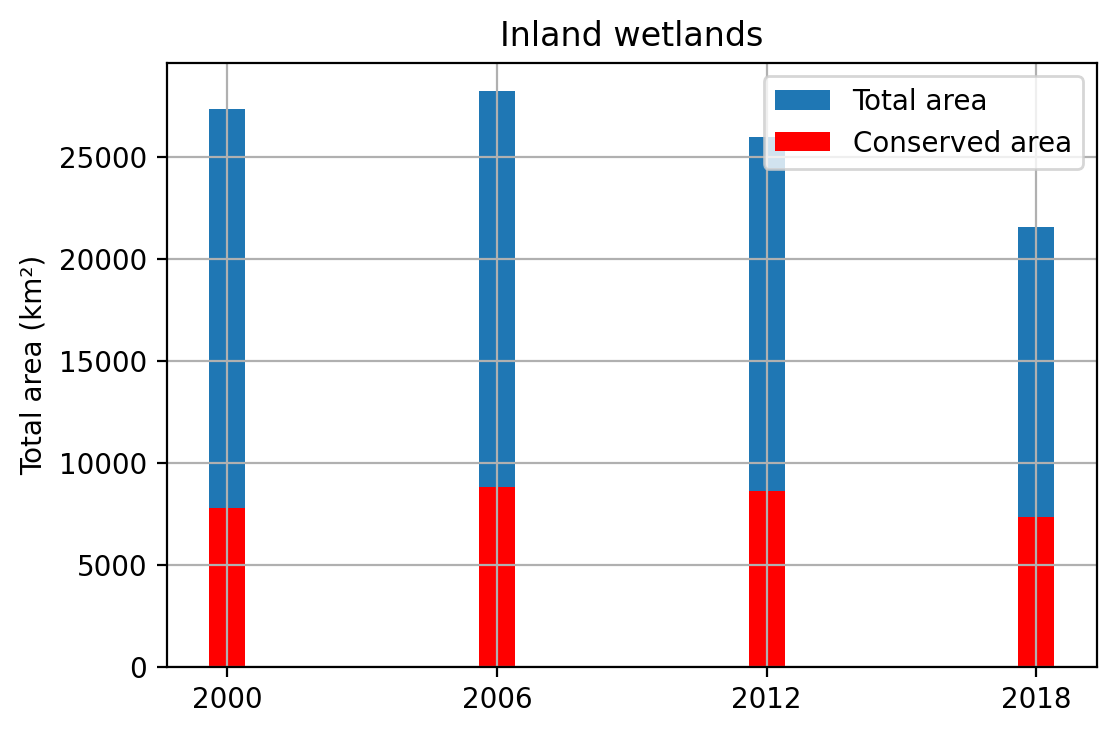

In [ ]:
swamp_cons_values = [clc_2000_natura[clc_2000_natura.Level2==41].tot_cons_area_km2.sum(),
                     clc_2006_natura[clc_2006_natura.Level2==41].tot_cons_area_km2.sum(),
                     clc_2012_natura[clc_2012_natura.Level2==41].tot_cons_area_km2.sum(),
                     clc_2018_natura[clc_2018_natura.Level2==41].tot_cons_area_km2.sum()]

swamp_values = [clc_2000_natura[clc_2000_natura.Level2==41].tot_area_km2.sum(),
                clc_2006_natura[clc_2006_natura.Level2==41].tot_area_km2.sum(),
                clc_2012_natura[clc_2012_natura.Level2==41].tot_area_km2.sum(),
                clc_2018_natura[clc_2018_natura.Level2==41].tot_area_km2.sum()]

fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])
ax.grid(True)
ax.set_ylabel('Total area (km²)')

ax.bar(x=[2000,2006,2012,2018], height=swamp_values)
ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_values, color='Red')
plt.title('Inland wetlands')
plt.legend(['Total area', 'Conserved area'])
plt.show()

Text(0.5, 1.0, 'Forest classes')

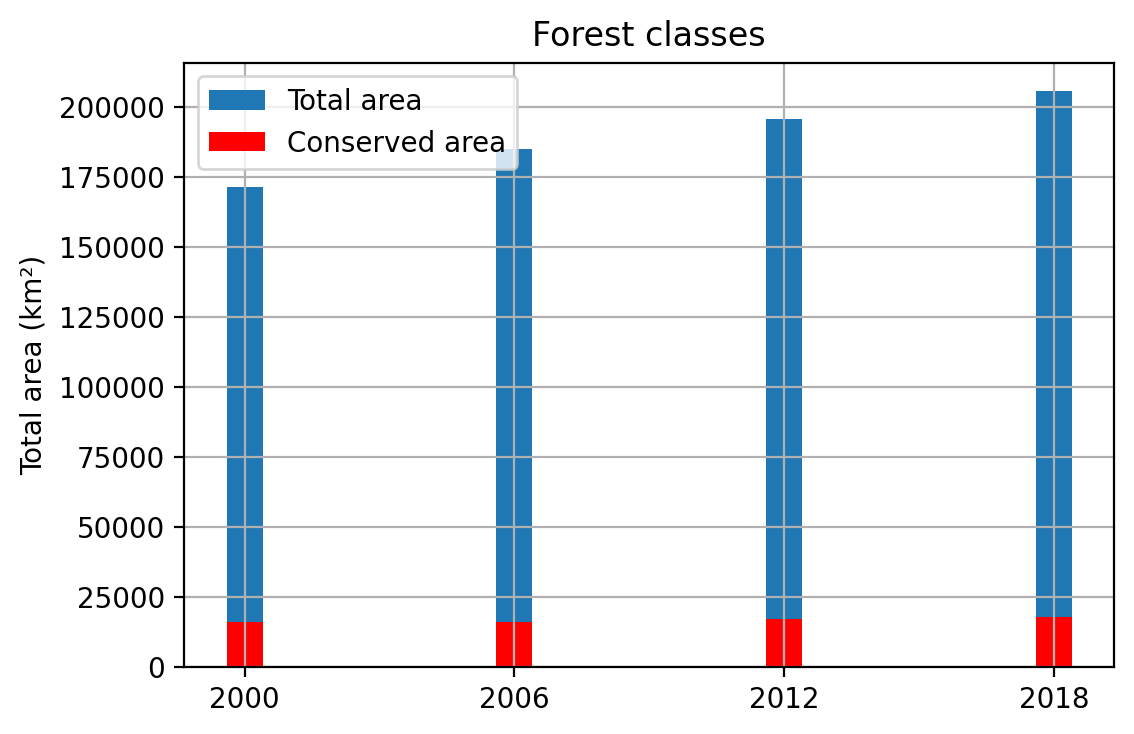

In [ ]:
forest_cons_values = [clc_2000_natura[clc_2000_natura.Level2==31].tot_cons_area_km2.sum(),
                      clc_2006_natura[clc_2006_natura.Level2==31].tot_cons_area_km2.sum(),
                      clc_2012_natura[clc_2012_natura.Level2==31].tot_cons_area_km2.sum(),
                      clc_2018_natura[clc_2018_natura.Level2==31].tot_cons_area_km2.sum()]

forest_values = [clc_2000_natura[clc_2000_natura.Level2==31].tot_area_km2.sum(),
                 clc_2006_natura[clc_2006_natura.Level2==31].tot_area_km2.sum(),
                 clc_2012_natura[clc_2012_natura.Level2==31].tot_area_km2.sum(),
                 clc_2018_natura[clc_2018_natura.Level2==31].tot_area_km2.sum()]

fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])
ax.set_ylabel('Total area (km²)')
ax.grid(True)
ax.bar(x=[2000,2006,2012,2018], height=forest_values)
ax.bar(x=[2000,2006,2012,2018], height=forest_cons_values, color='Red')
plt.legend(['Total area', 'Conserved area'])
plt.title('Forest classes')

## CDDA

CDDA data contains IUCN category, that can and possibly should be used to group the data. The following function derives the areas for each IUCN category, using only the areas founded at the time of CLC inventory.

In [ ]:
# export

def conserved_areas_for_year_cdda(path_to_raster, path_to_corine, path_to_cdda, year:int) -> pd.DataFrame:
    """Derive the total area for each CLC class and total areas for each IUCN category present in the 
    `path_to_cdda` data. Returns the original `path_to_corine` dataframe with additional columns
    `tot_area_km2` (the full area covered by that class) and `cons_area_km2_<iucn_cat>` for each 
    IUCN category present. `year` is used to mask only with the areas founded before or during that year.
    """
    clc_classes = pd.read_excel(path_to_corine) # Corines are xls files, todo fix for csv maybe
    clc_classes.dropna(subset='Value', inplace=True)
    conservation = gpd.read_file(path_to_cdda)
    conservation = conservation[conservation.legalFoundationDate <= year] 
    
    with rio.open(path_to_raster) as src:
        im = src.read()[0]
        res = src.profile['transform'][0] # square pixels, this is size in meters
    uniq, counts = np.unique(im, return_counts=True)
    uniq_dict = {u: c for u, c in zip(uniq, counts)}
    uniq_dict.pop(255, None) # We don't need nodata
    
    outdf = clc_classes.copy()
    
    # Area of a single pixel is res**2 m²
    outdf['tot_area_km2'] = outdf.Value.apply(lambda row: uniq_dict[row]*res**2 / 10**6
                                              if row in uniq_dict.keys() else 0)
    
    for iucn_cat in cdda.iucnCategory.unique():
        tempgeom = conservation[conservation.iucnCategory == iucn_cat].copy()
        with rio.open(path_to_raster) as src:
            im, tfm = rio_mask.mask(src, tempgeom.geometry, crop=True)

        uniq, counts = np.unique(im, return_counts=True)
        uniq_dict = {u: c for u, c in zip(uniq, counts)}
        uniq_dict.pop(255, None) # We don't need nodata
        outdf[f'cons_area_km2_{iucn_cat}'] = outdf.Value.apply(lambda row: uniq_dict[row]*res**2 / 10**6
                                                               if row in uniq_dict.keys() else 0)
    return outdf

In [ ]:
clc_2000_cdda = conserved_areas_for_year_cdda(corine_2000_folder/'Clc2000_FI25m.tif',
                                              corine_2000_folder/'classes.xls',
                                              cdda_path/'cdda16_fi.gpkg', year=2000)

100%|██████████| 7/7 [03:05<00:00, 26.46s/it]


In [ ]:
clc_2006_cdda = conserved_areas_for_year_cdda(corine_2006_folder/'Clc2006_FI25m.tif',
                                              corine_2006_folder/'classes.xls',
                                              cdda_path/'cdda16_fi.gpkg', year=2006)

100%|██████████| 7/7 [03:22<00:00, 28.89s/it]


In [ ]:
clc_2012_cdda = conserved_areas_for_year_cdda(corine_2012_folder/'clc2012_fi20m.tif',
                                              corine_2012_folder/'classes.xls',
                                              cdda_path/'cdda16_fi.gpkg', year=2012)

100%|██████████| 7/7 [05:24<00:00, 46.39s/it]


In [ ]:
clc_2018_cdda = conserved_areas_for_year_cdda(corine_2018_folder/'Clc2018_FI20m.tif',
                                              corine_2018_folder/'classes.xls',
                                              cdda_path/'cdda16_fi.gpkg', year=2018)

100%|██████████| 7/7 [05:33<00:00, 47.58s/it]


Fix labeling

In [ ]:
clc_2000_cdda.loc[clc_2000_cdda.Level1Suo == 'Vesialueet', 'Level1'] = 5

Derive total conserved areas.

In [ ]:
clc_2000_cdda['tot_cons_area_km2'] = (clc_2000_cdda.cons_area_km2_Ia + clc_2000_cdda.cons_area_km2_Ib + 
                                      clc_2000_cdda.cons_area_km2_II + clc_2000_cdda.cons_area_km2_III + 
                                      clc_2000_cdda.cons_area_km2_IV + clc_2000_cdda.cons_area_km2_notAssigned + 
                                      clc_2000_cdda.cons_area_km2_V)

In [ ]:
clc_2006_cdda['tot_cons_area_km2'] = (clc_2006_cdda.cons_area_km2_Ia + clc_2006_cdda.cons_area_km2_Ib + 
                                      clc_2006_cdda.cons_area_km2_II + clc_2006_cdda.cons_area_km2_III + 
                                      clc_2006_cdda.cons_area_km2_IV + clc_2006_cdda.cons_area_km2_notAssigned + 
                                      clc_2006_cdda.cons_area_km2_V)

In [ ]:
clc_2012_cdda['tot_cons_area_km2'] = (clc_2012_cdda.cons_area_km2_Ia + clc_2012_cdda.cons_area_km2_Ib + 
                                      clc_2012_cdda.cons_area_km2_II + clc_2012_cdda.cons_area_km2_III + 
                                      clc_2012_cdda.cons_area_km2_IV + clc_2012_cdda.cons_area_km2_notAssigned + 
                                      clc_2012_cdda.cons_area_km2_V)

In [ ]:
clc_2018_cdda['tot_cons_area_km2'] = (clc_2018_cdda.cons_area_km2_Ia + clc_2018_cdda.cons_area_km2_Ib + 
                                      clc_2018_cdda.cons_area_km2_II + clc_2018_cdda.cons_area_km2_III + 
                                      clc_2018_cdda.cons_area_km2_IV + clc_2018_cdda.cons_area_km2_notAssigned + 
                                      clc_2018_cdda.cons_area_km2_V)

Plot the total areas for swamps.

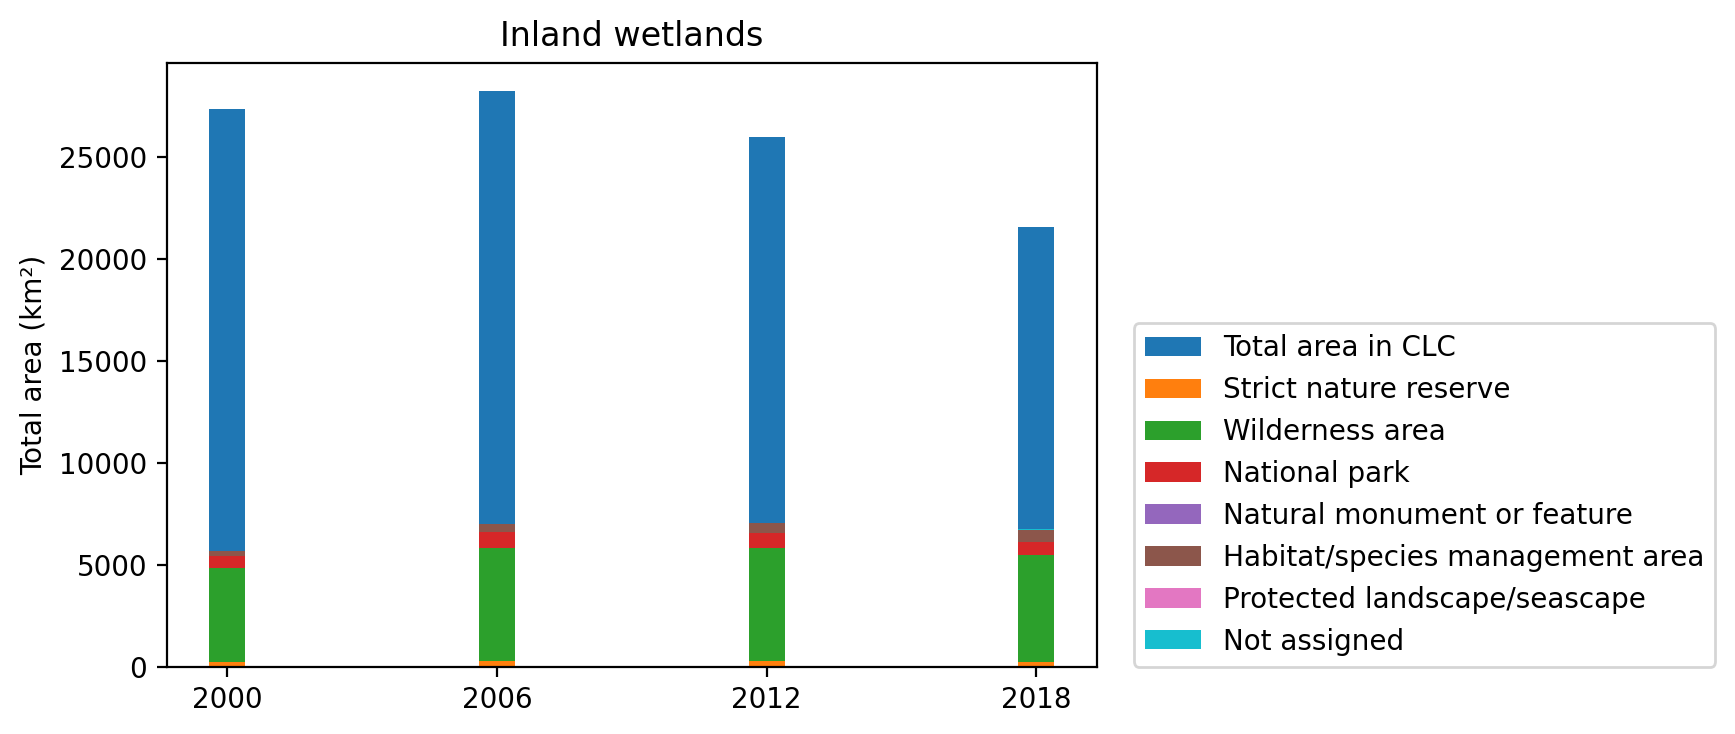

In [ ]:
swamp_values = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==41].tot_area_km2.sum()])

swamp_cons_ia = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_Ia.sum()])

swamp_cons_ib = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_Ib.sum()]) 

swamp_cons_ii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_II.sum()])

swamp_cons_iii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_III.sum()])

swamp_cons_iv = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_IV.sum()]) 

swamp_cons_v = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_V.sum()])

swamp_cons_na = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_notAssigned.sum()])

fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])
ax.set_ylabel('Total area (km²)')

ax.bar(x=[2000,2006,2012,2018], height=swamp_values, color='tab:blue')
ia = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ia, color='tab:orange')
ib = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ib, color='tab:green', bottom=swamp_cons_ia)
ii = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ii, color='tab:red', bottom=swamp_cons_ib+swamp_cons_ia)
iii = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_iii, color='tab:purple', 
             bottom=swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
iv = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_iv, color='tab:brown', 
            bottom=swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
v = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_v, color='tab:pink', 
           bottom=swamp_cons_iv+swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
na = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_na, color='tab:cyan', 
            bottom=swamp_cons_v+swamp_cons_iv+swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)


plt.title('Inland wetlands')
plt.legend(['Total area in CLC','Strict nature reserve', 'Wilderness area', 'National park', 'Natural monument or feature',
            'Habitat/species management area', 'Protected landscape/seascape', 'Not assigned'], loc=(1.04,0))
plt.show()

Same, but as the percentage of the total area.

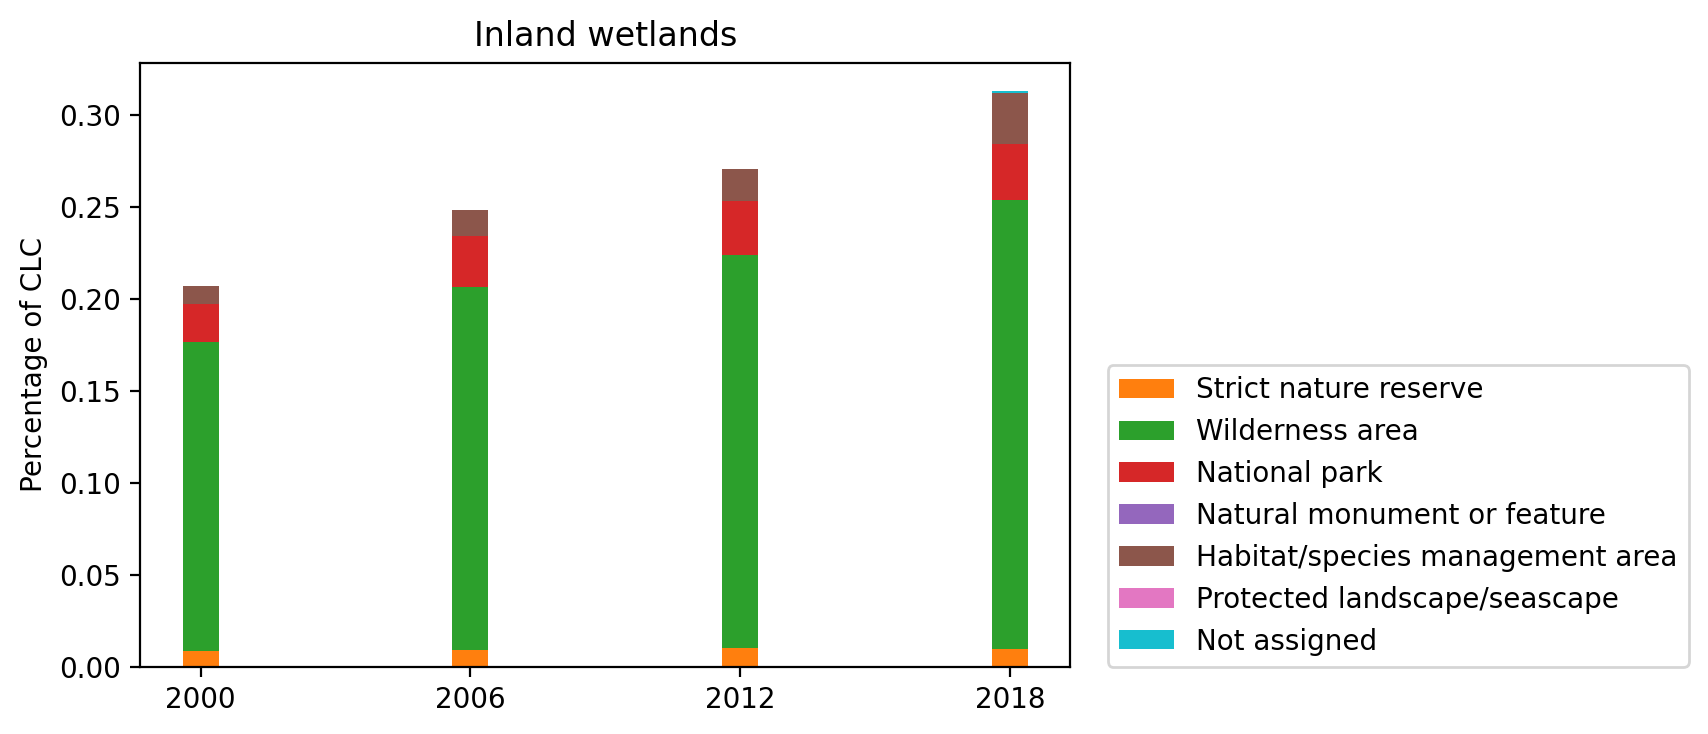

In [ ]:
swamp_values = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==41].tot_area_km2.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==41].tot_area_km2.sum()])

swamp_cons_ia = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_Ia.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_Ia.sum()]) / swamp_values

swamp_cons_ib = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_Ib.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_Ib.sum()]) / swamp_values

swamp_cons_ii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_II.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_II.sum()]) / swamp_values

swamp_cons_iii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_III.sum(),
                           clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_III.sum()]) / swamp_values

swamp_cons_iv = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_IV.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_IV.sum()]) / swamp_values

swamp_cons_v = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_V.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_V.sum()]) / swamp_values

swamp_cons_na = np.array([clc_2000_cdda[clc_2000_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==41].cons_area_km2_notAssigned.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==41].cons_area_km2_notAssigned.sum()]) / swamp_values



fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])
ax.set_ylabel('Percentage of CLC')

ia = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ia, color='tab:orange')
ib = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ib, color='tab:green', bottom=swamp_cons_ia)
ii = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_ii, color='tab:red', bottom=swamp_cons_ib+swamp_cons_ia)
iii = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_iii, color='tab:purple', 
             bottom=swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
iv = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_iv, color='tab:brown', 
            bottom=swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
v = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_v, color='tab:pink', 
           bottom=swamp_cons_iv+swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)
na = ax.bar(x=[2000,2006,2012,2018], height=swamp_cons_na, color='tab:cyan', 
            bottom=swamp_cons_v+swamp_cons_iv+swamp_cons_iii+swamp_cons_ii+swamp_cons_ib+swamp_cons_ia)


plt.title('Inland wetlands')
plt.legend(['Strict nature reserve', 'Wilderness area', 'National park', 'Natural monument or feature',
            'Habitat/species management area', 'Protected landscape/seascape', 'Not assigned'], loc=(1.04,0))
plt.show()

Same for forests.

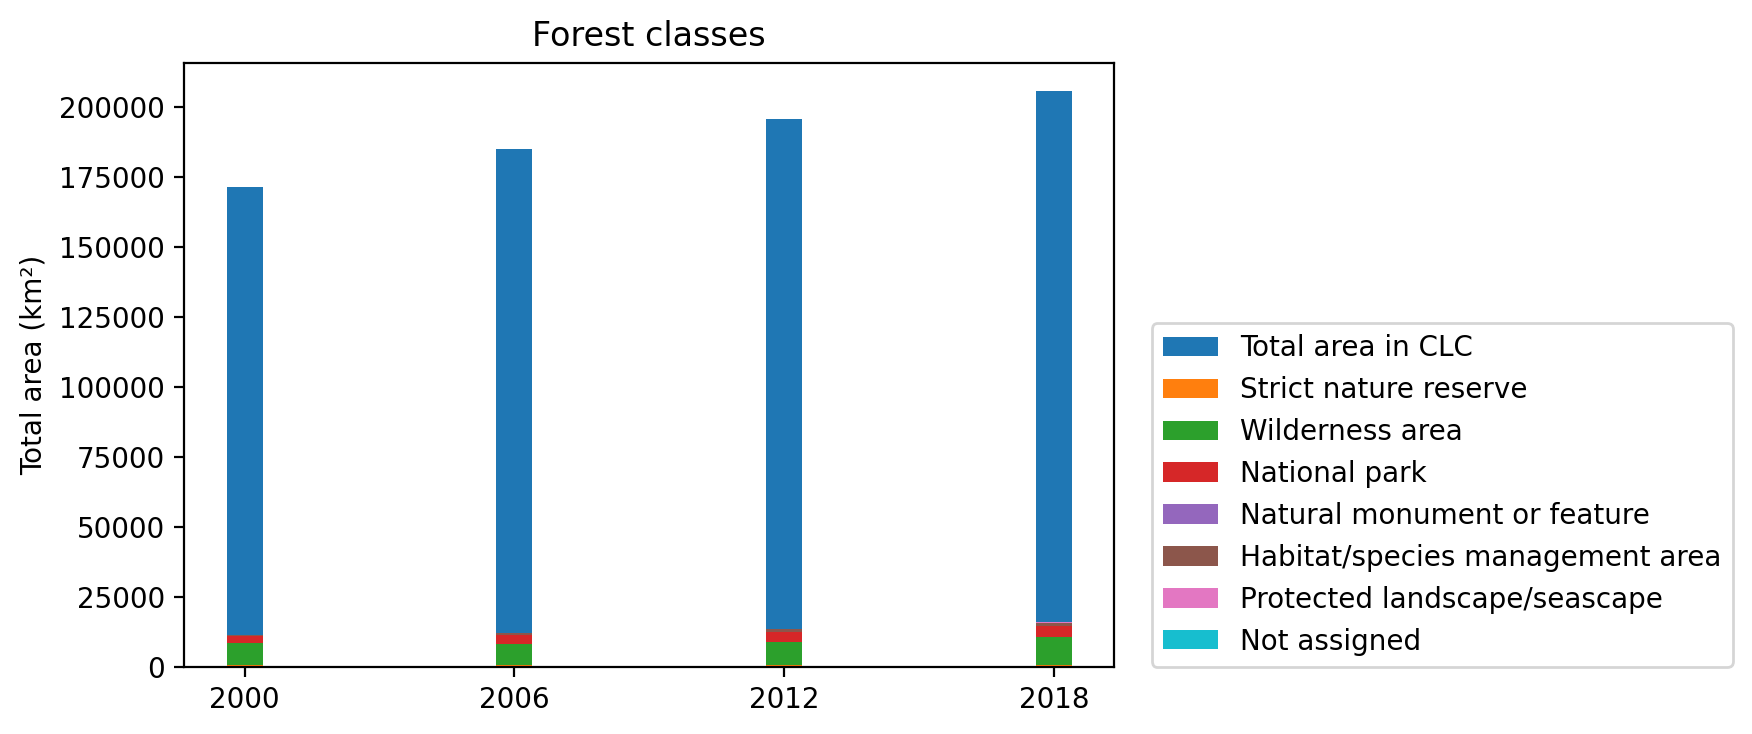

In [ ]:
fores_values = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==31].tot_area_km2.sum()])

fores_cons_ia = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_Ia.sum()])

fores_cons_ib = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_Ib.sum()]) 

fores_cons_ii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_II.sum()])

fores_cons_iii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_III.sum()])

fores_cons_iv = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_IV.sum()]) 

fores_cons_v = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_V.sum()])

fores_cons_na = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_notAssigned.sum()])



fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])
ax.set_ylabel('Total area (km²)')

ax.bar(x=[2000,2006,2012,2018], height=fores_values, color='tab:blue')
ia = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ia, color='tab:orange')
ib = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ib, color='tab:green', bottom=fores_cons_ia)
ii = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ii, color='tab:red', bottom=fores_cons_ib+fores_cons_ia)
iii = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_iii, color='tab:purple', 
             bottom=fores_cons_ii+fores_cons_ib+fores_cons_ia)
iv = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_iv, color='tab:brown', 
            bottom=fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)
v = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_v, color='tab:pink', 
           bottom=fores_cons_iv+fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)
na = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_na, color='tab:cyan', 
            bottom=fores_cons_v+fores_cons_iv+fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)


plt.title('Forest classes')
plt.legend(['Total area in CLC','Strict nature reserve', 'Wilderness area', 'National park', 'Natural monument or feature',
            'Habitat/species management area', 'Protected landscape/seascape', 'Not assigned'], loc=(1.04,0))
plt.show()

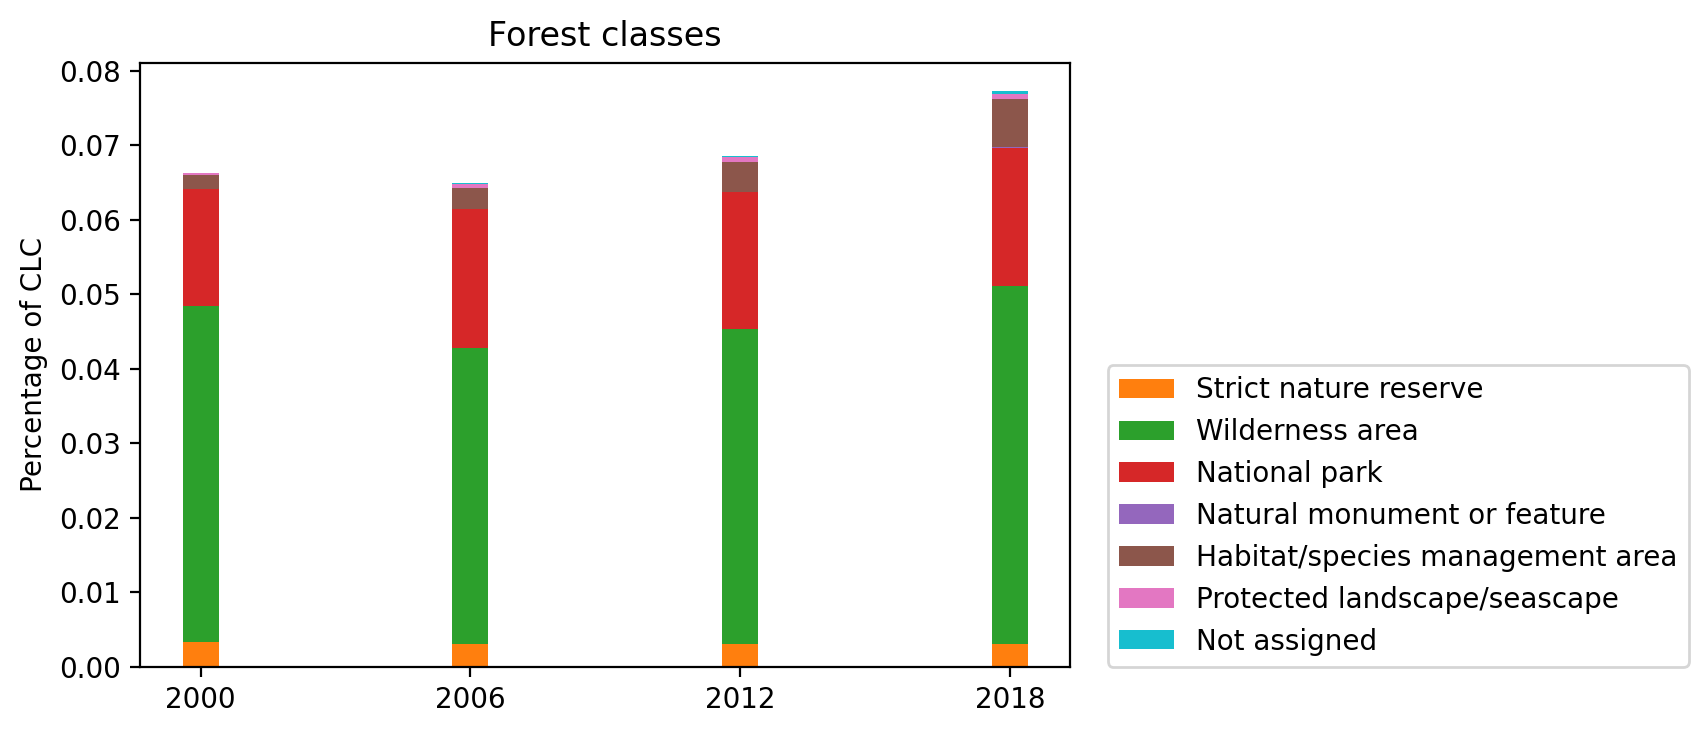

In [ ]:
fores_values = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==31].tot_area_km2.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==31].tot_area_km2.sum()])

fores_cons_ia = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_Ia.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_Ia.sum()]) / fores_values

fores_cons_ib = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_Ib.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_Ib.sum()]) / fores_values

fores_cons_ii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_II.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_II.sum()]) / fores_values

fores_cons_iii = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_III.sum(),
                           clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_III.sum()]) / fores_values

fores_cons_iv = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_IV.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_IV.sum()]) / fores_values

fores_cons_v = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_V.sum(),
                         clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_V.sum()]) / fores_values

fores_cons_na = np.array([clc_2000_cdda[clc_2000_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2006_cdda[clc_2006_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2012_cdda[clc_2012_cdda.Level2==31].cons_area_km2_notAssigned.sum(),
                          clc_2018_cdda[clc_2018_cdda.Level2==31].cons_area_km2_notAssigned.sum()]) / fores_values



fig, ax = plt.subplots(1,1, dpi=200)
ax.set_xticks([2000,2006,2012,2018])

ax.set_ylabel('Percentage of CLC')

ia = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ia, color='tab:orange')
ib = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ib, color='tab:green', bottom=fores_cons_ia)
ii = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_ii, color='tab:red', bottom=fores_cons_ib+fores_cons_ia)
iii = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_iii, color='tab:purple', 
             bottom=fores_cons_ii+fores_cons_ib+fores_cons_ia)
iv = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_iv, color='tab:brown', 
            bottom=fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)
v = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_v, color='tab:pink', 
           bottom=fores_cons_iv+fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)
na = ax.bar(x=[2000,2006,2012,2018], height=fores_cons_na, color='tab:cyan', 
            bottom=fores_cons_v+fores_cons_iv+fores_cons_iii+fores_cons_ii+fores_cons_ib+fores_cons_ia)


plt.title('Forest classes')
plt.legend(['Strict nature reserve', 'Wilderness area', 'National park', 'Natural monument or feature',
            'Habitat/species management area', 'Protected landscape/seascape', 'Not assigned'], loc=(1.04,0))
plt.show()